TEST MNIST

In [ ]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

!pip install mitdeeplearning
import mitdeeplearning as mdl

import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
train_labels = (train_labels).astype(np.int64)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)
test_labels = (test_labels).astype(np.int64)

11501568/11490434 [==============================] - 0s 0us/step


TRAIN MNIST

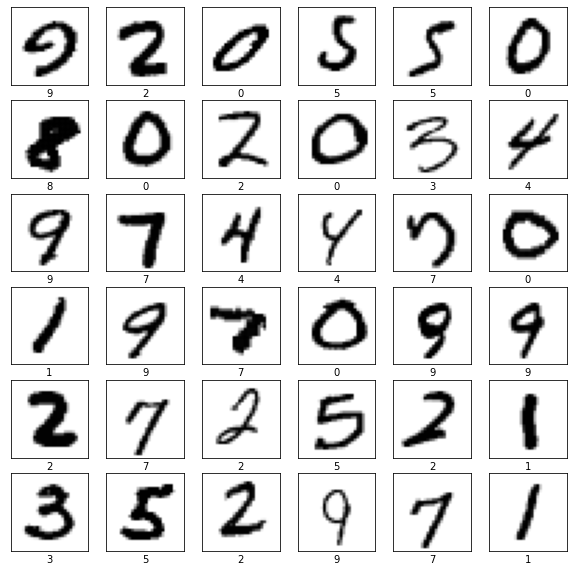

In [ ]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(train_images[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(train_labels[image_ind])

TEST CALIFORNIA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [ ]:
import numpy.random as rnd
rnd.seed(42)

In [ ]:
from sklearn.pipeline import Pipeline,FeatureUnion


In [ ]:
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin

class FeaturesAdder(BaseEstimator,TransformerMixin):
    """This class adds new features in the dataset.
        Features added are : rooms_per_household, bedrooms_per_room, and population_per_household.
    """
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        X['rooms_per_household']=X['total_rooms']/X['households']
        X['bedrooms_per_room']=X['total_bedrooms']/X['total_rooms']
        X['population_per_household']=X['population']/X['households']
        return X


class RemoveOutliers(BaseEstimator,TransformerMixin):
    """This class removes outliers from data.
    Note: Outlier values are hard coded
    """
    def fit (self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        X=X[(X['median_house_value']!=500001) | (X['median_income']>=2)].reset_index(drop=True)
        X=X[X['median_income']<=11].reset_index(drop=True)
        X=X[(X['median_house_value']!=350000) | (X['median_income']>=1.5)].reset_index(drop=True)
        X=X[(X['median_house_value']!=450000) | (X['median_income']>=2)].reset_index(drop=True)
        X=X[(X['median_house_value']>=350000) | (X['median_income']<=9.5)].reset_index(drop=True)
        X=X[X['population']<=9000]
        X=X[(X['population_per_household']>=1.15) & (X['population_per_household']<=6.5)]
        X=X[X['rooms_per_household']<20]
        X=X[X['bedrooms_per_room']<0.5].reset_index(drop=True)
        return X
    

class FeaturesTransformer(BaseEstimator,TransformerMixin):
    """This class trnsforms numberical featuress in the dataset.
    Note: Transformations are hard coded.
    """
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        import numpy as np
        from scipy.special import boxcox1p        
        X['total_rooms']=X['total_rooms'].apply(lambda x: boxcox1p(x,0.25))
        X['total_bedrooms']=X['total_bedrooms'].apply(lambda x: boxcox1p(x,0.25))
        X['households']=X['households'].apply(lambda x: boxcox1p(x,0.2))
        X['population']=X['population'].apply(lambda x: boxcox1p(x,0.3))
        X['rooms_per_household']=X['rooms_per_household'].apply(lambda x: np.log1p(x)**0.5)
        X['bedrooms_per_room']=X['bedrooms_per_room'].apply(lambda x: np.log1p(x)**0.25)
        X['median_income']=X['median_income'].apply(lambda x: np.log1p(x)**1.25)
        X['population_per_household']=X['population_per_household'].apply(lambda x: np.log1p(x)**1)
        return X
    

class DataFrameSelector(BaseEstimator,TransformerMixin):
    """This class is a dataframe selector.
        Data members:
            features: A list of column_names you want in output dataframe
    """
    def __init__(self,features):
        self.features=features
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return X[self.features]

class GetDummies(BaseEstimator,TransformerMixin):
    """This class is used to get dummy columns from categorical columns."""
    def fit (self,X,y=None):
        return self
    def transform(self,X,y=None):
        #change ISLAND to NEAR BAY...as count of ISLAND is very low
        X[X=='ISLAND']='NEAR BAY'
        return (pd.get_dummies(X,drop_first=True))

In [ ]:
def remove_by_pvalue(X,y,pvalue=0.05):
    """Remove features with p-value more than 'pvalue'
    
    This function uses statsmodels.api.OLS model. Please add intercept to data externally.
    Input:
        X: Array or dataframe excluding predicted variable
        y: Series or list of predicted variable
        pvalue: int or float
    
    Note:
        X is changed inplace
    """
    import statsmodels.api as sm
    for i in range(len(X.columns)):
        regressor_OLS=sm.OLS(endog=y,exog=X).fit()
        s=regressor_OLS.pvalues.sort_values(ascending=False)
        if s.iloc[0]>pvalue:
            X.drop(s.index[0],axis=1,inplace=True)
            print('Removed: ',s.index[0],'P-value: ',s.iloc[0])
        
def remove_by_vif(X,vif=5):
    """Remove columns from X whose VIF is greater than supplied 'vif'
    Parameters:
        X:array or dataframe containing data excluding target variable
        vif: int or float of limiting value of VIF
    Note:
        This function changes X inplace
    """
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor
        
    for i in range(len(X.columns)):
        l = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        s=pd.Series(index=X.columns,data=l).sort_values(ascending=False)
        if s.iloc[0]>vif:
            X.drop(s.index[0],axis=1,inplace=True)
            print('Removed: ',s.index[0],', VIF: ',s.iloc[0])
        else:
            break

TRAIN CALIFORNIA

In [ ]:
df=pd.read_csv('/content/sample_data/california_housing_train.csv')

In [ ]:
#Adding features
df=FeaturesAdder().fit_transform(df)

num_features=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'rooms_per_household',
       'bedrooms_per_room', 'population_per_household']

#Transforming features
df=FeaturesTransformer().fit_transform(df)

num_features=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_household','bedrooms_per_room', 'population_per_household']
cat_featues=['ocean_proximity']

#Mean value imputation, feature scaling, gettin gdummy variables
num_pipeline=Pipeline([
    ('selector',DataFrameSelector(num_features)),
])

cat_pipeline=Pipeline([
    ('selector',DataFrameSelector(cat_featues)),
    ('get_dummies',GetDummies())
])

#Combining numerical and categorica data
data_cleaning_pipeline=FeatureUnion(transformer_list=[
    ('num_pipeline',num_pipeline),
    ('cat_pipeline',cat_pipeline),  
])



l=num_features.copy()
l.extend([0,1,2])
df=pd.DataFrame(df,columns=l)

#Check for multicoliniearity



data_prepared=df
y_train=data_labels.copy()




In [ ]:
data_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16632 entries, 0 to 16631
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 16632 non-null  float64
 1   latitude                  16632 non-null  float64
 2   housing_median_age        16632 non-null  float64
 3   total_rooms               16632 non-null  float64
 4   total_bedrooms            16632 non-null  float64
 5   population                16632 non-null  float64
 6   households                16632 non-null  float64
 7   median_income             16632 non-null  float64
 8   rooms_per_household       16632 non-null  float64
 9   bedrooms_per_room         16632 non-null  float64
 10  population_per_household  16632 non-null  float64
 11  0                         0 non-null      float64
 12  1                         0 non-null      float64
 13  2                         0 non-null      float64
dtypes: flo

In [ ]:
ANSCOMBE

In [ ]:
[
  {"Series":"I", "X":10.0, "Y":8.04},
  {"Series":"I", "X":8.0, "Y":6.95},
  {"Series":"I", "X":13.0, "Y":7.58},
  {"Series":"I", "X":9.0, "Y":8.81},
  {"Series":"I", "X":11.0, "Y":8.33},
  {"Series":"I", "X":14.0, "Y":9.96},
  {"Series":"I", "X":6.0, "Y":7.24},
  {"Series":"I", "X":4.0, "Y":4.26},
  {"Series":"I", "X":12.0, "Y":10.84},
  {"Series":"I", "X":7.0, "Y":4.81},
  {"Series":"I", "X":5.0, "Y":5.68},
  
  {"Series":"II", "X":10.0, "Y":9.14},
  {"Series":"II", "X":8.0, "Y":8.14},
  {"Series":"II", "X":13.0, "Y":8.74},
  {"Series":"II", "X":9.0, "Y":8.77},
  {"Series":"II", "X":11.0, "Y":9.26},
  {"Series":"II", "X":14.0, "Y":8.10},
  {"Series":"II", "X":6.0, "Y":6.13},
  {"Series":"II", "X":4.0, "Y":3.10},
  {"Series":"II", "X":12.0, "Y":9.13},
  {"Series":"II", "X":7.0, "Y":7.26},
  {"Series":"II", "X":5.0, "Y":4.74},
  
  {"Series":"III", "X":10.0, "Y":7.46},
  {"Series":"III", "X":8.0, "Y":6.77},
  {"Series":"III", "X":13.0, "Y":12.74},
  {"Series":"III", "X":9.0, "Y":7.11},
  {"Series":"III", "X":11.0, "Y":7.81},
  {"Series":"III", "X":14.0, "Y":8.84},
  {"Series":"III", "X":6.0, "Y":6.08},
  {"Series":"III", "X":4.0, "Y":5.39},
  {"Series":"III", "X":12.0, "Y":8.15},
  {"Series":"III", "X":7.0, "Y":6.42},
  {"Series":"III", "X":5.0, "Y":5.73},
  
  {"Series":"IV", "X":8.0, "Y":6.58},
  {"Series":"IV", "X":8.0, "Y":5.76},
  {"Series":"IV", "X":8.0, "Y":7.71},
  {"Series":"IV", "X":8.0, "Y":8.84},
  {"Series":"IV", "X":8.0, "Y":8.47},
  {"Series":"IV", "X":8.0, "Y":7.04},
  {"Series":"IV", "X":8.0, "Y":5.25},
  {"Series":"IV", "X":19.0, "Y":12.50},
  {"Series":"IV", "X":8.0, "Y":5.56},
  {"Series":"IV", "X":8.0, "Y":7.91},
  {"Series":"IV", "X":8.0, "Y":6.89}
]

[{'Series': 'I', 'X': 10.0, 'Y': 8.04},
 {'Series': 'I', 'X': 8.0, 'Y': 6.95},
 {'Series': 'I', 'X': 13.0, 'Y': 7.58},
 {'Series': 'I', 'X': 9.0, 'Y': 8.81},
 {'Series': 'I', 'X': 11.0, 'Y': 8.33},
 {'Series': 'I', 'X': 14.0, 'Y': 9.96},
 {'Series': 'I', 'X': 6.0, 'Y': 7.24},
 {'Series': 'I', 'X': 4.0, 'Y': 4.26},
 {'Series': 'I', 'X': 12.0, 'Y': 10.84},
 {'Series': 'I', 'X': 7.0, 'Y': 4.81},
 {'Series': 'I', 'X': 5.0, 'Y': 5.68},
 {'Series': 'II', 'X': 10.0, 'Y': 9.14},
 {'Series': 'II', 'X': 8.0, 'Y': 8.14},
 {'Series': 'II', 'X': 13.0, 'Y': 8.74},
 {'Series': 'II', 'X': 9.0, 'Y': 8.77},
 {'Series': 'II', 'X': 11.0, 'Y': 9.26},
 {'Series': 'II', 'X': 14.0, 'Y': 8.1},
 {'Series': 'II', 'X': 6.0, 'Y': 6.13},
 {'Series': 'II', 'X': 4.0, 'Y': 3.1},
 {'Series': 'II', 'X': 12.0, 'Y': 9.13},
 {'Series': 'II', 'X': 7.0, 'Y': 7.26},
 {'Series': 'II', 'X': 5.0, 'Y': 4.74},
 {'Series': 'III', 'X': 10.0, 'Y': 7.46},
 {'Series': 'III', 'X': 8.0, 'Y': 6.77},
 {'Series': 'III', 'X': 13.0, 'Y': 12.7

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
